# Lab 4 - Part 2: Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training.

## Import resources

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

2024-10-09 16:20:37.444830: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 16:20:37.447707: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 16:20:37.456580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 16:20:37.471617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 16:20:37.475927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 16:20:37.485671: I tensorflow/core/platform/cpu_feature_gu

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.17.0
	• GPU device not found. Running on CPU


I0000 00:00:1728483644.956759   15251 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-09 16:20:44.977877: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


We are now going to load the Fashion-MNIST dataset using tensorflow_datasets as we've done before. In this case, however, we are going to define how to split the dataset ourselves. We are going to split the dataset such that 60\% of the data will be used for training, 20\% of the data will be used for validation, and the remaining 20\% of the data will be used for testing.

To do this, we are going to do two things in succession. First we are going to combine (merge) the `train` and `test` splits. After the splits are merged into a single set, we are going to sub-split it into three sets, where the first set has 60\% of the data, the second set has 20\% of the data, and the third set has the remaining 20\% of the data.

To learn more about `split`, visit the [Split Documentation](https://www.tensorflow.org/datasets/splits#subsplit).

In [6]:
train_split = 60
test_val_split = 20

splits = ['train[:20%]+test[:20%]', 'train[20%:40%]+test[20%:40%]', 'train[40%:]+test[40%:]']

dataset, dataset_info = tfds.load('fashion_mnist', split=splits, as_supervised=True, with_info=True)

training_set, validation_set, test_set = dataset

I0000 00:00:1728483733.836331   15251 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-09 16:22:13.839470: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
print("Train set size: ", len(training_set))
print("Valid set size: ", len(validation_set))
print("Test set size:  ", len(test_set))

Train set size:  14000
Valid set size:  14000
Test set size:   42000


In [8]:
# Check that dataset is a tuple
print('dataset has type:', type(dataset))

# Print the number of elements in dataset
print('dataset has {:,} elements '.format(len(dataset)))

dataset has type: <class 'list'>
dataset has 3 elements 


In [ ]:
# Display dataset_info
dataset_info

## Explore the dataset

In [10]:
images=["hard-leaved_pocket_orchid.jpg","cautleya_spicata.jpg","orange_dahlia.jpg","wild_pansy.jpg"]
for imag in images:
    print('There are {} images in the training set'.format(imag))

There are hard-leaved_pocket_orchid.jpg images in the training set
There are cautleya_spicata.jpg images in the training set
There are orange_dahlia.jpg images in the training set
There are wild_pansy.jpg images in the training set


In [13]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = (total_examples * train_split) // 100
num_validation_examples = (total_examples * test_val_split) // 100
num_test_examples = num_validation_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

There are 42,000 images in the training set
There are 14,000 images in the validation set
There are 14,000 images in the test set


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Create pipeline

In [14]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build the model

Here we'll build and compile our model as usual.

In [15]:
# your solution Here
model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape = (28, 28, 1),padding='same'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
                tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,402 (1.37 MB)

 Trainable params: 359,402 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer= 'adam',
              loss= 'sparse_categorical_crossentropy',
              metrics= ['accuracy']
)

## Evaluate loss and accuracy on the test set

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. Let's see how the model performs on our test set.

In [ ]:
# you answer here
loss, accuracy = model.evaluate(###)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

The network is untrained so it's making random guesses and we should see an accuracy around 10%.

## Train the model with the validation set

Now let's train our network as usual, but this time we are also going to incorporate our validation set into the training process.

During training, the model will only use the training set in order to decide how to modify its weights and biases. Then, after every training epoch we calculate the loss on the training and validation sets. These metrics tell us how well our model is "learning" because it they show how well the model generalizes to data that is not used for training. It's important to remember that the model does not use any part of the validation set to tune its weights and biases, therefore it can tell us if we're overfitting the training set.

We can incorporate our validation set into the training process by including the `validation_data=validation_batches` argument in the `.fit` method.

In [18]:
# your solution here
EPOCHS = 30

history = model.fit(training_batches, validation_data=validation_batches, epochs=EPOCHS)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9923 - loss: 0.0227 - val_accuracy: 0.8903 - val_loss: 0.5367
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9915 - loss: 0.0258 - val_accuracy: 0.8887 - val_loss: 0.5064
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9840 - loss: 0.0425 - val_accuracy: 0.8980 - val_loss: 0.5933
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9932 - loss: 0.0195 - val_accuracy: 0.8985 - val_loss: 0.5029
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9913 - loss: 0.0265 - val_accuracy: 0.8997 - val_loss: 0.5666
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9923 - loss: 0.0218 - val_accuracy: 0.8967 - val_loss: 0.6384
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9932 - loss: 0.0209 - val_accuracy: 0.9019 - val_loss: 0.5615
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9975 - loss: 0.0081 - val_accu

## Loss and validation plots

If we look at the training and validation losses achieved on epoch 30 above, we see that the loss on the training set is much lower than that achieved on the validation set. This is a clear sign of overfitting. In other words, our model has "memorized" the training set so it performs really well on it, but when tested on data that it wasn't trained on (*i.e.* the validation dataset) it performs poorly.

Let's take a look at the model's loss and accuracy values obtained during training on both the training set and the validation set. This will allow us to see how well or how bad our model is "learning". We can do this easily by using the `history` object returned by the `.fit` method. The  `history.history` attribute is a **dictionary** with a record of training accuracy and loss values at successive epochs, as well as validation accuracy and loss values when applicable.

In [19]:
# Check that history.history is a dictionary
print('history.history has type:', type(history.history))

# Print the keys of the history.history dictionary
print('\nThe keys of history.history are:', list(history.history.keys()))

history.history has type: <class 'dict'>

The keys of history.history are: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


Let's use the `history.history` dictionary to plot our model's loss and accuracy values obtained during training.

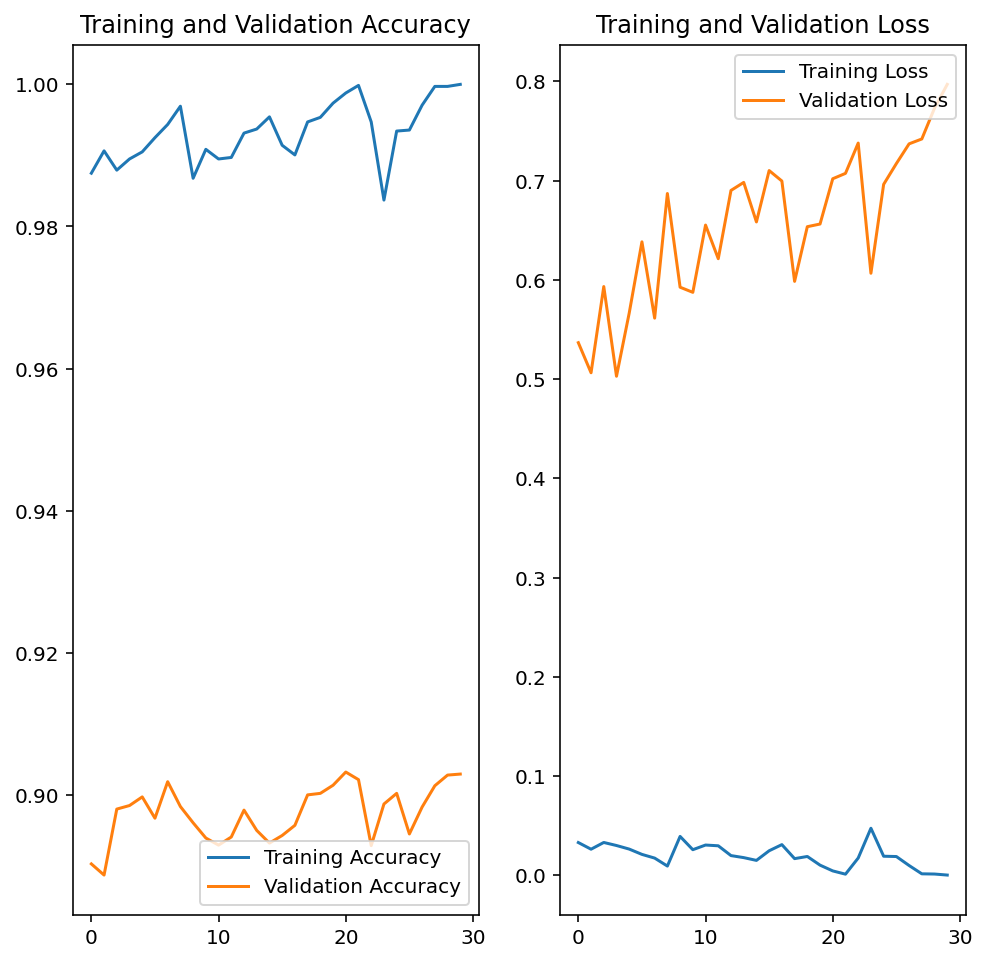

In [20]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Early stopping

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.
This happens when our model performs really well on the training data but it fails to generalize well enough to also perform well on the validation set. We can tell that this is happening because when we finished training the validation loss is higher than the training loss.

One way to prevent our model from overfitting is by stopping training when we achieve the lowest validation loss. If we take a look at the plots we can see that at the beginning of training the validation loss starts decreasing, then after some epochs it levels off, and then it just starts increasing. Therefore, we can stop training our model when the validation loss levels off, such that our network is accurate but it's not overfitting.

This strategy is called **early-stopping**. We can implement early stopping in `tf.keras` by using a **callback**. A callback is a set of functions to be applied at given stages of the training process. You can pass a list of callbacks to the `.fit()` method by using the `callbacks` keyword argument.

To implement early-stopping during training we will use the callback:


```python
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
```

The `monitor` argument specifies the quantity we want to monitor during training to determine when to stop training. The `patience` argument determines the number of consecutive epochs with no significant improvement after which training will be stopped. We can also specify the minimum change in the monitored quantity to qualify as an improvement, by specifying the `min_delta` argument. For more information on the early-stopping callback check out the [EarlyStopping
documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping#class_earlystopping).

In [ ]:
# your answer here
model =  ###


model.compile(optimizer= ##,
              loss=##,
              metrics=['accuracy'] )


# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Dropout

Another common method to reduce overfitting is called **dropout**, where we randomly drop neurons in our model during training. This forces the network to share information between weights, increasing its ability to generalize to new data. We can implement dropout in `tf.keras` by adding `tf.keras.layers.Dropout()` layers to our models.

```python
tf.keras.layers.Dropout(rate)
```
randomly sets a fraction `rate` of the dropout layer's input units to 0 at each update during training. The `rate` argument is a float between 0 and 1, that determines the fraction of neurons from the previous layer that should be turned off. For example,  `rate =0.5` will drop 50\% of the neurons.

It's important to note that we should never apply dropout to the input layer of our network. Also, remember that during training we want to use dropout to prevent overfitting, but during inference we want to use all the neurons in the network. `tf.keras` is designed to care of this automatically, so it uses the dropout layers during training, but automatically ignores them during inference.

> **Exercise:** Add 3 dropout layers with a `rate=0.2` to our previous `model` and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [ ]:
## Solution
rate=0.2
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs = 30,
                    validation_data=validation_batches
                    )

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

Now that the model is trained, we can use it to perform inference. Here we are going to perform inference on 30 images and print the labels in green if our model's prediction matches the true label. On the other hand, if our model's prediction doesn't match the true label, we print the label in red.

In [ ]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()


plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

## Try all steps above using your `CNN Network`
Compare your results in DNN vs CNN network : you need to build and train your CNN

## Next Up!

In the next part, we'll see how to save our trained models. In general, you won't want to train a model every time you need it. Instead, you'll train once, save it, then load the model when you want to train more or use it for inference.